## Install the package dependencies before running this notebook

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os, os.path 
import numpy as np
import pickle
from glob import glob
import matplotlib.pyplot as plt
from ArgoDataset import ArgoverseDataset, get_city_trajectories, show_sample_batch

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "validation", "test"]

## Create a Torch.Dataset class for the training dataset

In [2]:
def transform(data):
    # currently 109 input - 109 out
    inp = np.concatenate((data[0], data[1][:-1]))
    out = np.concatenate((data[0][1:], data[1]))

    return (inp, out)

In [3]:
train_dataset  = ArgoverseDataset(city = "all", split = "train", transform=transform)
print(train_dataset[0][0])

(163052, 50, 4)
[[ 0.00000000e+00  0.00000000e+00  2.32355047e-04 -2.61898208e-04]
 [ 2.32355047e-04 -2.61898208e-04  2.83106447e-04 -1.72075379e-04]
 [ 5.15461494e-04 -4.33973588e-04  2.89754875e-04 -9.04206324e-05]
 [ 8.05216369e-04 -5.24394220e-04  3.55379236e-04 -1.78365758e-04]
 [ 1.16059560e-03 -7.02759978e-04  4.90603405e-04 -4.49648609e-05]
 [ 1.65119901e-03 -7.47724839e-04  5.09982608e-04  2.79746472e-04]
 [ 2.16118162e-03 -4.67978366e-04  3.29833242e-04 -7.04496475e-04]
 [ 2.49101486e-03 -1.17247484e-03  2.53010107e-04 -1.07292516e-03]
 [ 2.74402497e-03 -2.24540000e-03  4.49352730e-04  5.53389174e-04]
 [ 3.19337770e-03 -1.69201083e-03  5.66244619e-04  2.03115941e-03]
 [ 3.75962231e-03  3.39148584e-04  4.77710266e-04  3.28149800e-03]
 [ 4.23733258e-03  3.62064658e-03  3.44300471e-04  4.21188901e-03]
 [ 4.58163305e-03  7.83253559e-03  2.59591253e-04  4.54597614e-03]
 [ 4.84122431e-03  1.23785117e-02  2.94585910e-04  4.39379794e-03]
 [ 5.13581022e-03  1.67723097e-02  3.37603479e

# Model Constants

In [40]:
batch_sz = 32  # batch size
input_size = 4
hidden_size = 128
output_size = 4
dropout = 0.5
inp_seq_len = 50
num_epochs = 15
num_base_epochs = 5
lr = 1e-4
lr_spec = 5e-6

# Baseplate Model

In [6]:
from models import LSTM
from tqdm import tqdm

city_loss_all=dict()
print("Training model baseplate")
# train_dataset  = ArgoverseDataset(city = "all", split = "train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size = batch_sz, shuffle = True)
val_dataset = ArgoverseDataset(city = "all", split = "validation")
val_loader = DataLoader(val_dataset, batch_size=batch_sz*2, shuffle=True)
val_iter = iter(val_loader)

BEST_PATH = "./models/all_best.pt"
PATH = "./models/baseplate.pt"
best_err = 10000000000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rnn = LSTM(input_size, hidden_size, output_size, dropout, device).cuda()
criterion = torch.nn.MSELoss()
criterion.to(device)
opt = torch.optim.Adam(rnn.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.5)

print_every = 1000
val_every = 8
plot_every = 500 / (batch_sz/4)
train_loss = 0
val_loss = 0
train_losses = [-1]
val_losses = [-1]
# fig = plt.figure()

rnn.train()
for epoch in range(num_base_epochs):
    current_loss = 0
    val_iter = iter(val_loader)
    for s_num, (x, y) in tqdm(enumerate(train_loader), \
                              "val_loss: %.3f, best_val: %.3f, train_loss: %.3f, epoch #%d" % (val_losses[-1], best_err, train_losses[-1], epoch)):
        x, y = x.to(torch.float32).to(device), y.to(torch.float32).to(device)

        opt.zero_grad()
        loss = 0

        y_hat = rnn(x)
        loss = criterion(y_hat, y)

        loss.backward()
        opt.step()

        # Validate every so often
        if s_num % val_every == 0:
            with torch.no_grad():
                rnn.eval()
                vx, vy = next(val_iter)
                vx, vy = vx.to(torch.float32).to(device), vy.to(torch.float32).to(device)
                vy_hat = rnn(vx)
                val_loss += criterion(vy_hat, vy)
                del vx
                del vy
                rnn.train()

        # Keep track of average losses
        current_loss += loss.item()
        if s_num != 0 and s_num % plot_every == 0:
            with torch.no_grad():
                train_losses.append(current_loss / plot_every)
                current_loss = 0
                val_losses.append(val_loss / plot_every)
                val_loss = 0
            if val_losses[-1] < best_err:
                torch.save(rnn, BEST_PATH)
                best_err = val_losses[-1]
            scheduler.step(val_losses[-1])
        del x
        del y

city_loss_all["train"] = train_losses
city_loss_all["val"] = val_losses
torch.save(rnn, PATH)

Training model baseplate
(40764, 50, 4)


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 5096it [02:43, 31.20it/s]
val_loss: 80.932, best_val: 73.546, train_loss: 215.994, epoch #1: 5096it [02:41, 31.55it/s]
val_loss: 37.289, best_val: 32.025, train_loss: 74.940, epoch #2: 5096it [02:24, 35.18it/s]
val_loss: 21.227, best_val: 18.142, train_loss: 32.592, epoch #3: 5096it [02:27, 34.52it/s]
val_loss: 13.418, best_val: 12.922, train_loss: 23.659, epoch #4: 5096it [02:19, 36.49it/s]


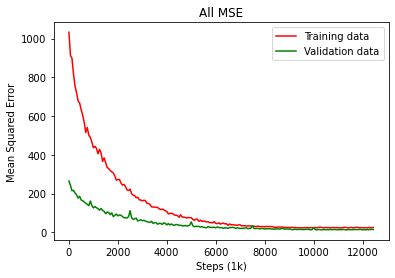

In [25]:
plt.figure()
plt.plot(np.array(range(len(city_loss_all["train"][1:])))*plot_every, city_loss_all["train"][1:],'-r', label="Training data")
plt.plot(np.array(range(len(city_loss_all["val"][1:])))*plot_every, city_loss_all["val"][1:],'-g', label="Validation data")
plt.gca().set_xlabel("Steps")
plt.gca().set_ylabel("Mean Squared Error")
plt.gca().set_title("All MSE")
plt.legend()
plt.show()

(40764, 50, 4)
tensor(53.4051, device='cuda:0')


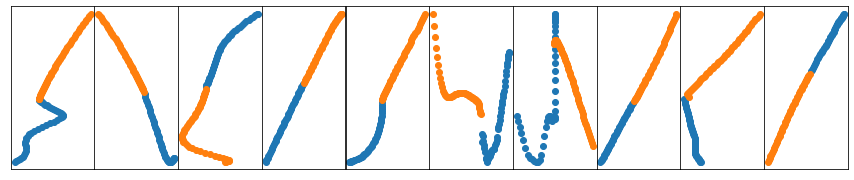

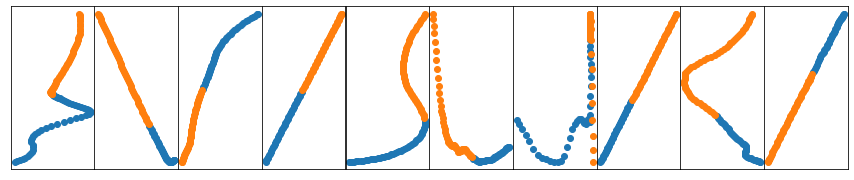

In [9]:
with torch.no_grad():
    rnn = torch.load(f"./models/baseplate.pt").to(device)
    rnn.eval()
    val_dataset = ArgoverseDataset(city = "all", split = "validation")
    val_loader = DataLoader(val_dataset, batch_size=batch_sz*2, shuffle=True)
    x, y = next(iter(val_loader))
    x, y = x.to(torch.float32).to(device), y.to(torch.float32).to(device)
    y_hat = rnn(x[:, :inp_seq_len])
    loss = torch.nn.MSELoss()
    print(loss(y_hat, y))
    show_sample_batch((x[0:10, :inp_seq_len].cpu(), y_hat.cpu()[0:10]))
    show_sample_batch((x[0:10, :inp_seq_len].cpu(), y[0:10].cpu()))
    plt.show()

# Model Training

In [44]:
from models import LSTM
from tqdm import tqdm

city_loss = dict()

for city in cities:
    city_loss[city]=dict()
    print(f"Training model for {city}")
    train_dataset  = ArgoverseDataset(city = city, split = "train", transform=transform)
    train_loader = DataLoader(train_dataset, batch_size = batch_sz, shuffle = True)
    val_dataset = ArgoverseDataset(city = city, split = "validation")
    val_loader = DataLoader(val_dataset, batch_size=batch_sz*2, shuffle=True)
    val_iter = iter(val_loader)

    BEST_PATH = f"./models/{city}_best.pt"
    PATH = f"./models/{city}.pt"
    best_err = 10000000000

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     rnn = LSTM(input_size, hidden_size, output_size, dropout, device).cuda()
    rnn = torch.load(f"./models/baseplate.pt").to(device)
    criterion = torch.nn.MSELoss()
    criterion.to(device)
    opt = torch.optim.Adam(rnn.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
    # scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.5)

    print_every = 1000
    val_every = 8
    plot_every = 500 / (batch_sz/4)
    train_loss = 0
    val_loss = 0
    train_losses = [-1]
    val_losses = [-1]
    # fig = plt.figure()

    rnn.train()
    for epoch in range(num_epochs):
        current_loss = 0
        val_iter = iter(val_loader)
        for s_num, (x, y) in tqdm(enumerate(train_loader), \
                                  "val_loss: %.3f, best_val: %.3f, train_loss: %.3f, epoch #%d" % (val_losses[-1], best_err, train_losses[-1], epoch)):
            x, y = x.to(torch.float32).to(device), y.to(torch.float32).to(device)

            opt.zero_grad()
            loss = 0

            y_hat = rnn(x)
            loss = criterion(y_hat, y)

            loss.backward()
            opt.step()

            # Validate every so often
            if s_num % val_every == 0:
                with torch.no_grad():
                    rnn.eval()
                    vx, vy = next(val_iter)
                    vx, vy = vx.to(torch.float32).to(device), vy.to(torch.float32).to(device)
                    vy_hat = rnn(vx)
                    val_loss += criterion(vy_hat, vy)
                    del vx
                    del vy
                    rnn.train()

            # Keep track of average losses
            current_loss += loss.item()
            if s_num != 0 and s_num % plot_every == 0:
                with torch.no_grad():
                    train_losses.append(current_loss / plot_every)
                    current_loss = 0
                    val_losses.append(val_loss / plot_every)
                    val_loss = 0
                if val_losses[-1] < best_err:
                    torch.save(rnn, BEST_PATH)
                    best_err = val_losses[-1]
                scheduler.step(val_losses[-1])
            del x
            del y
            
    city_loss[city]["train"] = train_losses
    city_loss[city]["val"] = val_losses
    torch.save(rnn, PATH)

    del rnn
    del criterion
    del scheduler
    del opt
        

Training model for austin
(34432, 50, 4)
(8609, 50, 4)


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 1076it [00:28, 37.15it/s]
val_loss: 15.083, best_val: 13.974, train_loss: 24.799, epoch #1: 1076it [00:33, 32.57it/s]
val_loss: 17.199, best_val: 13.974, train_loss: 23.507, epoch #2: 1076it [00:32, 33.52it/s]
val_loss: 13.914, best_val: 11.603, train_loss: 21.628, epoch #3: 1076it [00:31, 34.53it/s]
val_loss: 12.598, best_val: 11.603, train_loss: 22.546, epoch #4: 1076it [00:32, 33.08it/s]
val_loss: 13.288, best_val: 11.430, train_loss: 21.956, epoch #5: 1076it [00:30, 34.94it/s]
val_loss: 13.676, best_val: 11.430, train_loss: 21.734, epoch #6: 1076it [00:31, 34.63it/s]
val_loss: 13.105, best_val: 11.430, train_loss: 22.275, epoch #7: 1076it [00:30, 35.02it/s]
val_loss: 12.806, best_val: 11.430, train_loss: 21.672, epoch #8: 1076it [00:30, 35.04it/s]
val_loss: 12.857, best_val: 11.430, train_loss: 23.009, epoch #9: 1076it [00:31, 33.92it/s]
val_loss: 12.621, best_val: 11.430, train_loss: 23.250, epoch #10: 1076

Training model for miami
(44023, 50, 4)
(11006, 50, 4)


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 1376it [00:40, 34.35it/s]
val_loss: 11.211, best_val: 10.098, train_loss: 15.769, epoch #1: 1376it [00:39, 34.87it/s]
val_loss: 9.112, best_val: 8.901, train_loss: 14.843, epoch #2: 1376it [00:39, 34.81it/s]
val_loss: 9.036, best_val: 8.295, train_loss: 14.633, epoch #3: 1376it [00:40, 34.34it/s]
val_loss: 8.527, best_val: 8.295, train_loss: 14.337, epoch #4: 1376it [00:39, 34.47it/s]
val_loss: 8.500, best_val: 8.295, train_loss: 14.248, epoch #5: 1376it [00:41, 32.87it/s]
val_loss: 8.824, best_val: 8.295, train_loss: 14.509, epoch #6: 1376it [00:39, 34.76it/s]
val_loss: 8.866, best_val: 8.295, train_loss: 14.462, epoch #7: 1376it [00:43, 31.93it/s]
val_loss: 9.037, best_val: 8.247, train_loss: 14.412, epoch #8: 1376it [00:40, 33.81it/s]
val_loss: 8.446, best_val: 7.658, train_loss: 14.765, epoch #9: 1376it [00:37, 36.87it/s]
val_loss: 8.492, best_val: 7.658, train_loss: 14.223, epoch #10: 1376it [00:27, 49.75it

Training model for pittsburgh
(34835, 50, 4)
(8709, 50, 4)


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 1089it [00:31, 34.96it/s]
val_loss: 10.660, best_val: 10.660, train_loss: 16.825, epoch #1: 1089it [00:31, 34.76it/s]
val_loss: 12.058, best_val: 10.660, train_loss: 16.346, epoch #2: 1089it [00:31, 34.17it/s]
val_loss: 10.962, best_val: 9.756, train_loss: 15.831, epoch #3: 1089it [00:31, 34.27it/s]
val_loss: 10.803, best_val: 9.756, train_loss: 15.349, epoch #4: 1089it [00:31, 34.60it/s]
val_loss: 9.097, best_val: 8.256, train_loss: 16.357, epoch #5: 1089it [00:31, 34.46it/s]
val_loss: 9.507, best_val: 8.222, train_loss: 14.808, epoch #6: 1089it [00:31, 34.56it/s]
val_loss: 8.140, best_val: 8.140, train_loss: 15.327, epoch #7: 1089it [00:31, 34.56it/s]
val_loss: 9.375, best_val: 8.140, train_loss: 15.350, epoch #8: 1089it [00:31, 35.01it/s]
val_loss: 8.881, best_val: 8.098, train_loss: 15.821, epoch #9: 1089it [00:31, 34.78it/s]
val_loss: 8.973, best_val: 7.492, train_loss: 14.467, epoch #10: 1089it [00:31, 35.

Training model for dearborn
(19572, 50, 4)
(4893, 50, 4)


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 612it [00:17, 34.82it/s]
val_loss: 20.216, best_val: 18.408, train_loss: 44.465, epoch #1: 612it [00:17, 34.78it/s]
val_loss: 19.972, best_val: 17.933, train_loss: 40.999, epoch #2: 612it [00:17, 34.47it/s]
val_loss: 19.639, best_val: 17.383, train_loss: 37.949, epoch #3: 612it [00:17, 34.35it/s]
val_loss: 18.214, best_val: 16.258, train_loss: 37.695, epoch #4: 612it [00:18, 33.86it/s]
val_loss: 17.485, best_val: 16.258, train_loss: 35.307, epoch #5: 612it [00:17, 35.88it/s]
val_loss: 17.346, best_val: 16.258, train_loss: 35.564, epoch #6: 612it [00:17, 35.55it/s]
val_loss: 14.546, best_val: 14.546, train_loss: 33.731, epoch #7: 612it [00:17, 35.00it/s]
val_loss: 14.825, best_val: 13.696, train_loss: 34.166, epoch #8: 612it [00:17, 34.89it/s]
val_loss: 14.132, best_val: 13.232, train_loss: 33.174, epoch #9: 612it [00:17, 35.51it/s]
val_loss: 14.859, best_val: 13.232, train_loss: 32.751, epoch #10: 612it [00:17, 

Training model for washington-dc
(20595, 50, 4)
(5149, 50, 4)


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 644it [00:17, 35.88it/s]
val_loss: 12.786, best_val: 11.829, train_loss: 19.653, epoch #1: 644it [00:16, 39.00it/s]
val_loss: 14.328, best_val: 11.829, train_loss: 19.684, epoch #2: 644it [00:18, 35.38it/s]
val_loss: 10.191, best_val: 10.191, train_loss: 19.602, epoch #3: 644it [00:18, 34.51it/s]
val_loss: 11.289, best_val: 9.712, train_loss: 18.619, epoch #4: 644it [00:19, 32.66it/s]
val_loss: 9.843, best_val: 9.712, train_loss: 17.793, epoch #5: 644it [00:19, 32.86it/s]
val_loss: 9.813, best_val: 9.701, train_loss: 18.821, epoch #6: 644it [00:20, 31.07it/s]
val_loss: 9.562, best_val: 9.562, train_loss: 17.958, epoch #7: 644it [00:20, 32.13it/s]
val_loss: 10.891, best_val: 9.562, train_loss: 19.046, epoch #8: 644it [00:19, 32.72it/s]
val_loss: 10.290, best_val: 9.562, train_loss: 18.765, epoch #9: 644it [00:18, 34.10it/s]
val_loss: 10.876, best_val: 9.501, train_loss: 18.635, epoch #10: 644it [00:18, 33.96it/s]

Training model for palo-alto
(9594, 50, 4)
(2399, 50, 4)


val_loss: -1.000, best_val: 10000000000.000, train_loss: -1.000, epoch #0: 300it [00:08, 34.85it/s]
val_loss: 21.949, best_val: 21.949, train_loss: 62.293, epoch #1: 300it [00:08, 34.72it/s]
val_loss: 20.586, best_val: 20.586, train_loss: 53.860, epoch #2: 300it [00:08, 34.29it/s]
val_loss: 19.713, best_val: 19.713, train_loss: 54.763, epoch #3: 300it [00:08, 34.81it/s]
val_loss: 21.118, best_val: 19.713, train_loss: 51.394, epoch #4: 300it [00:08, 35.31it/s]
val_loss: 21.716, best_val: 19.713, train_loss: 47.335, epoch #5: 300it [00:08, 33.98it/s]
val_loss: 18.191, best_val: 18.191, train_loss: 47.546, epoch #6: 300it [00:08, 34.72it/s]
val_loss: 20.297, best_val: 18.191, train_loss: 45.502, epoch #7: 300it [00:08, 35.29it/s]
val_loss: 21.108, best_val: 18.191, train_loss: 42.892, epoch #8: 300it [00:08, 35.38it/s]
val_loss: 18.383, best_val: 18.191, train_loss: 42.198, epoch #9: 300it [00:08, 34.60it/s]
val_loss: 17.997, best_val: 17.997, train_loss: 39.681, epoch #10: 300it [00:08, 

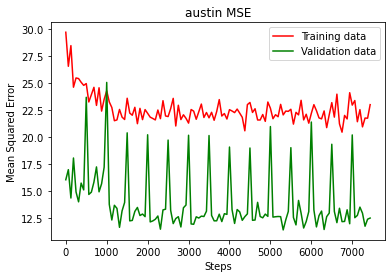

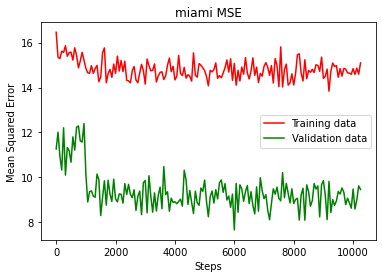

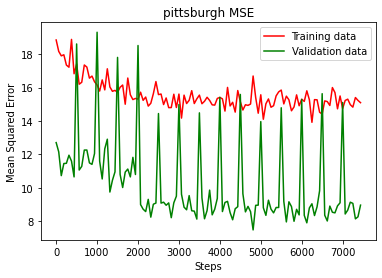

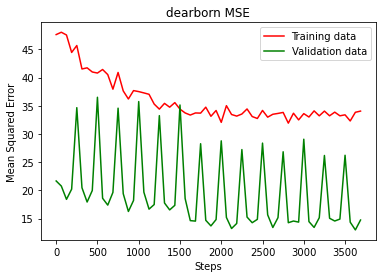

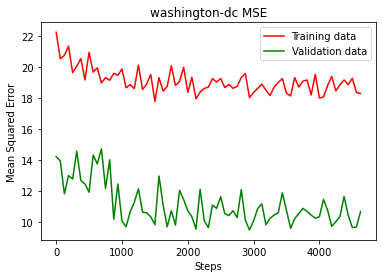

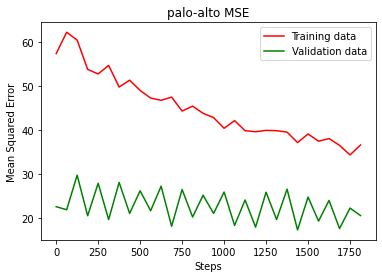

In [45]:
for i, city in enumerate(city_loss):
    plt.figure(i)
    plt.plot(np.array(range(len(city_loss[city]["train"][1:])))*plot_every, city_loss[city]["train"][1:],'-r', label="Training data")
    plt.plot(np.array(range(len(city_loss[city]["val"][1:])))*plot_every, city_loss[city]["val"][1:],'-g', label="Validation data")
    plt.gca().set_xlabel("Steps")
    plt.gca().set_ylabel("Mean Squared Error")
    plt.gca().set_title(f"{city} MSE")
    plt.legend()
    plt.show()

(8609, 50, 4)
tensor(44.1222, device='cuda:0')


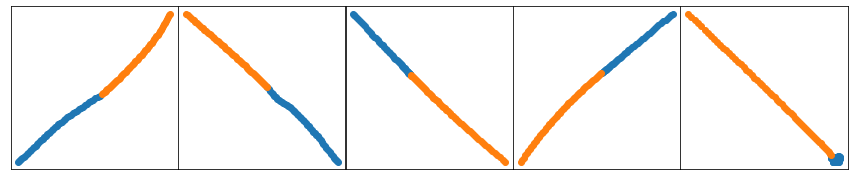

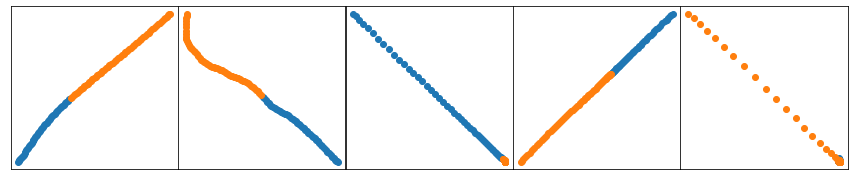

(11006, 50, 4)
tensor(34.8123, device='cuda:0')


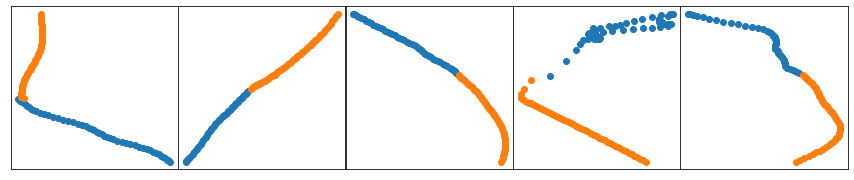

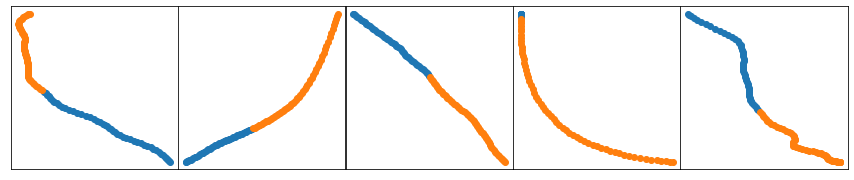

(8709, 50, 4)
tensor(34.1991, device='cuda:0')


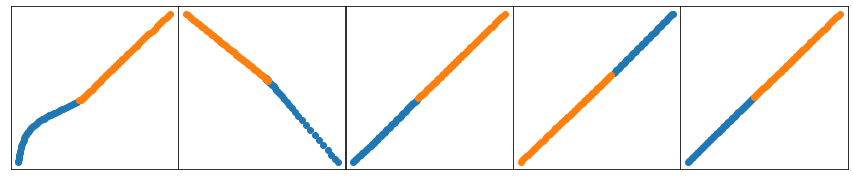

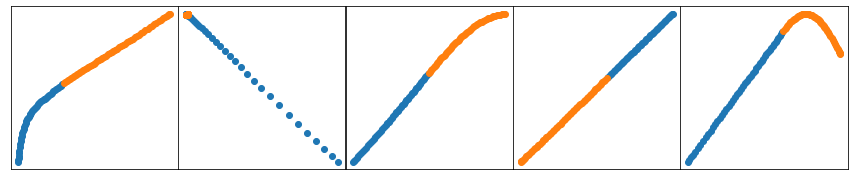

(4893, 50, 4)
tensor(59.4375, device='cuda:0')


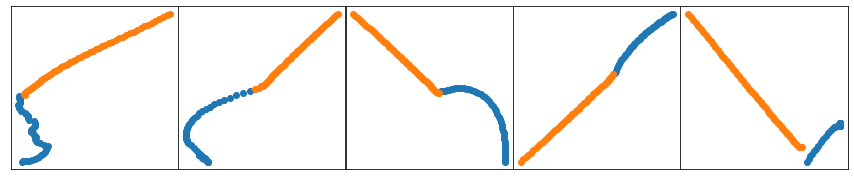

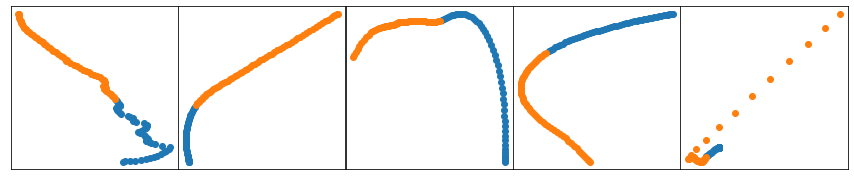

(5149, 50, 4)
tensor(38.5493, device='cuda:0')


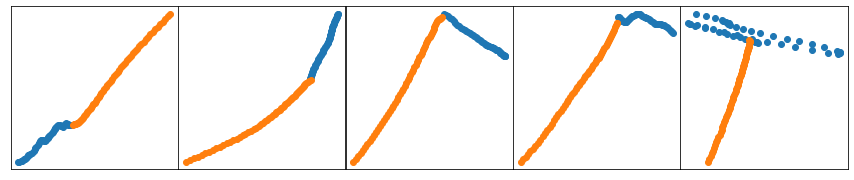

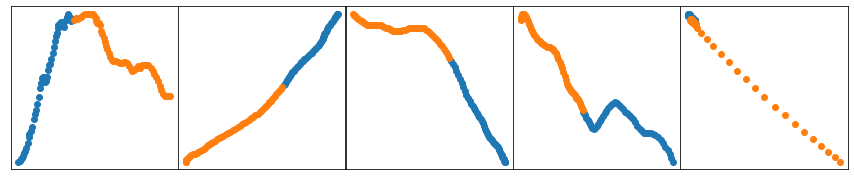

(2399, 50, 4)
tensor(79.4484, device='cuda:0')


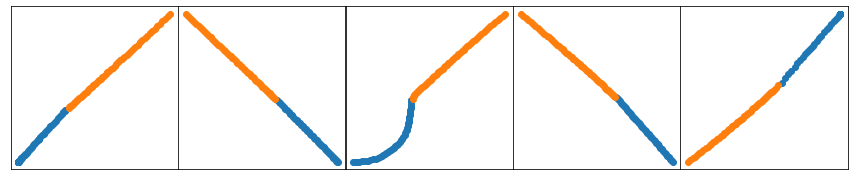

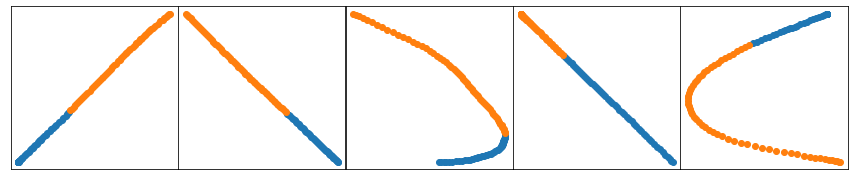

In [47]:
with torch.no_grad():
    for city in city_loss:
        rnn = torch.load(f"./models/{city}_best.pt").to(device)
        rnn.eval()
        val_dataset = ArgoverseDataset(city = city, split = "validation")
        val_loader = DataLoader(val_dataset, batch_size=batch_sz*2, shuffle=True)
        x, y = next(iter(val_loader))
        x, y = x.to(torch.float32).to(device), y.to(torch.float32).to(device)
        y_hat = rnn(x[:, :inp_seq_len])
        loss = torch.nn.MSELoss()
        print(loss(y_hat, y))
        show_sample_batch((x[0:5, :inp_seq_len].cpu(), y_hat.cpu()[0:5]))
#         del rnn
#         rnn = torch.load(f"./models/{city}.pt").to(device)
#         rnn.eval()
#         y_hat = rnn(x[:, :inp_seq_len])
#         loss = torch.nn.MSELoss()
#         print(loss(y_hat, y))
#         show_sample_batch((x[0:10, :inp_seq_len].cpu(), y_hat.cpu()[0:10]))
        show_sample_batch((x[0:5, :inp_seq_len].cpu(), y[0:5, :].cpu()))
        plt.show()
        del rnn

# Examining the submission format

In [33]:
import pandas as pd

In [7]:
sample_sub = pd.read_csv('./argo2/sample_submission.csv')
sample_sub.head()

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
%load_ext autoreload
%autoreload 2

In [9]:
from prediction import get_traj_pred

ModuleNotFoundError: No module named 'prediction'

Processing city austin
(6325, 50, 2)
(6325, 50, 4)
(6325, 60, 4)
(6325, 60, 2)
(6325, 120)
[  27.86433403 -580.02025069]
Processing city miami
(7971, 50, 2)
(7971, 50, 4)
(7971, 60, 4)
(7971, 60, 2)
(7971, 120)
[5928.7169812  1469.72844621]
Processing city pittsburgh
(6361, 50, 2)
(6361, 50, 4)
(6361, 60, 4)
(6361, 60, 2)
(6361, 120)
[4059.06160213  207.185043  ]
Processing city dearborn
(3671, 50, 2)
(3671, 50, 4)
(3671, 60, 4)
(3671, 60, 2)
(3671, 120)
[9384.91646135 3282.67523702]
Processing city washington-dc
(3829, 50, 2)
(3829, 50, 4)
(3829, 60, 4)
(3829, 60, 2)
(3829, 120)
[1540.78922806  720.24440437]
Processing city palo-alto
(1686, 50, 2)
(1686, 50, 4)
(1686, 60, 4)
(1686, 60, 2)
(1686, 120)
[ 566.7580094  1909.85977658]


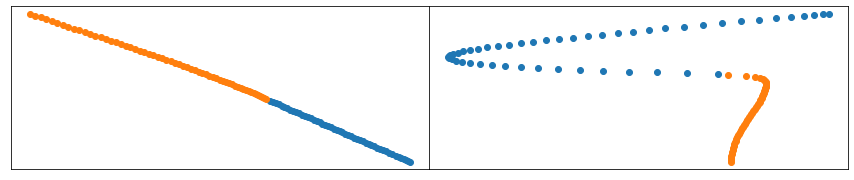

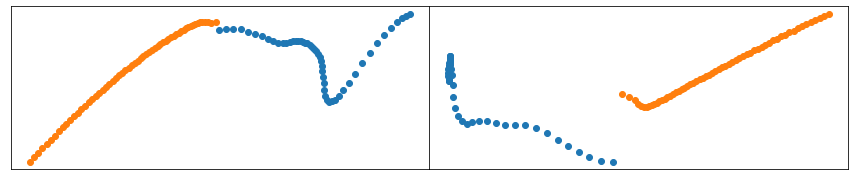

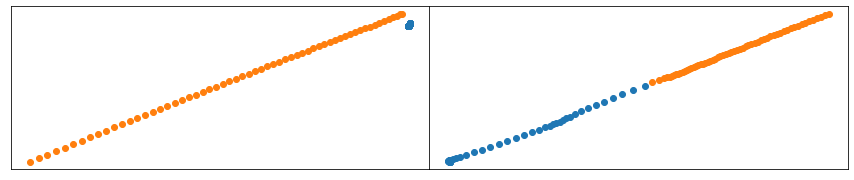

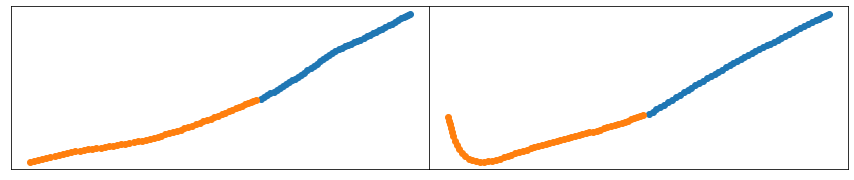

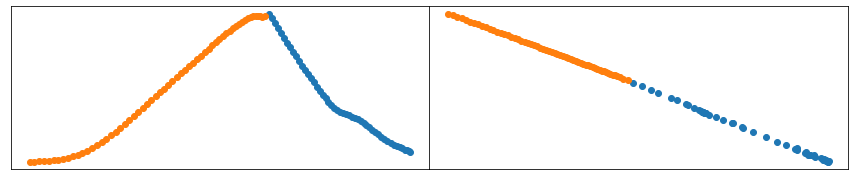

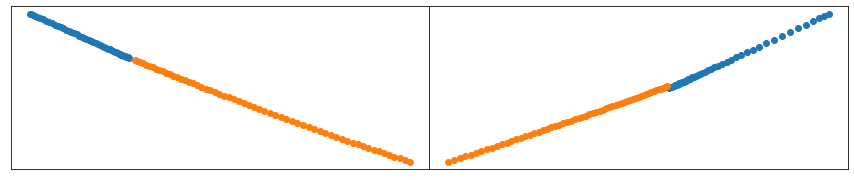

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_pred_steps = 60
all_preds = np.zeros(shape=(0, num_pred_steps * 2))
city_col = np.array([])
for city_name in cities:

    print("Processing city", city_name)
    rnn = torch.load(f"./models/{city_name}_best.pt").to(device)
    rnn.eval()
    test_traj_in, test_traj_out = get_city_trajectories(city=city_name, split="test")
    print(test_traj_in.shape)
#   normal_traj = np.zeros(shape=test_traj_in.shape)
    normal_traj  = ArgoverseDataset(city = city_name, split = "test").inputs

    starts = test_traj_in[:,0]

    traj = torch.from_numpy(normal_traj).to(torch.float32).to(device)
    test_pred_arr = rnn(traj).cpu().detach().numpy()
    print(test_pred_arr.shape)
    
    test_pred_arr = test_pred_arr[:,:,:2]
    print(test_pred_arr.shape)
    
    for i in range(test_traj_in.shape[0]):
        test_pred_arr[i]+=starts[i]
    
 
    
    test_pred_arr_reshaped = np.reshape(test_pred_arr, newshape=(test_traj_in.shape[0], num_pred_steps * 2))
    print(test_pred_arr_reshaped.shape)

    all_preds = np.r_[all_preds, test_pred_arr_reshaped]
    city_col = np.r_[city_col, [str(i) + "_" + city_name for i in range(test_pred_arr.shape[0])]]
    print(test_traj_in[0][0])
    show_sample_batch((torch.tensor(test_traj_in[0:2]), torch.tensor(test_pred_arr[0:2])))
    del rnn

In [36]:
sub_df = pd.DataFrame(np.c_[city_col, all_preds], columns=[np.r_[["ID"], ["v" + str(i) for i in range(120)]]])
sub_df.to_csv('./submissions/baseplate_spec.csv', index=None)